In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare data file

In [2]:
df_raw = pd.read_csv('csgo_profiles_raw.csv')

In [3]:
# normalize all continuous variables
def normalize(df, numeric_only=True):
    col_to_normalize = np.setdiff1d(df.columns, ['goal_id', 'new_rank'])
    # subtracy mean and divide by std
    
    for col in col_to_normalize:
        df[col] = (df[col] - df[col].mean())/df[col].std()
    
    return df

In [4]:
# drop records that has null playing records
df = df_raw.dropna(subset=['total_kills','total_deaths','total_time_played','total_rounds_played',
                                             'total_shots_fired'], how = 'any')
df.fillna(0, inplace=True)

# add ratio features
df['kill_death_ratio'] = df['total_kills']/df['total_deaths']
df['headshot_ratio'] = df['total_kills_headshot']/df['total_kills']
df['accuracy'] = df['total_shots_hit']/df['total_shots_fired']
df['win_rate'] = df['total_wins']/df['total_rounds_played']
df['mvp_percentage'] = df['total_mvps']/df['total_rounds_played']
df['average_time_per_round'] = df['total_time_played']/df['total_rounds_played']
df['average_kill'] = df['total_time_played']/df['total_kills']
df['average_death'] = df['total_time_played']/df['total_deaths']

# split rank into three categories
rank_ids = df['rank_id'].values
new_rank_ids = []

for r in rank_ids:
    
    if r <=6:
        new_rank_ids.append(0)
    elif r <=12:
        new_rank_ids.append(1)
    else:
        new_rank_ids.append(2)
        
df = pd.concat( [df, pd.DataFrame(new_rank_ids, columns=['new_rank'], index = df.index)] , axis = 1 )

# remove obvious cheaters
df = df[(df['total_time_played'] > 0) & (df['total_shots_fired'] > 0) & (df['total_deaths'] > 0) &
        (df['total_shots_fired'] > df['total_kills']) & (df['total_kills_headshot'] < df['total_kills']) &  
        (df['total_time_played'] <= 1963*12*60*60) & (df['total_mvps']<df['total_rounds_played']) & 
        (df['total_deaths']<1963*12*30) & (df['total_kills']<df['total_rounds_played']*9) & 
        (df['win_rate']<1) & (df['accuracy']<1)]

# drop useless columns
df = df.drop(['user_id', 'nickname', 'steam_id', 'about', 'updated_at', 'compensation', 'rank_id'], axis = 1)

# normalize values
df = normalize(df)
df = pd.concat([df, pd.get_dummies( df['goal_id'], prefix = 'goal_')], axis = 1)
df.columns

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Index(['total_kills', 'total_deaths', 'total_time_played',
       'total_kills_headshot', 'total_shots_hit', 'total_mvps', 'total_wins',
       'total_rounds_played', 'total_shots_fired', 'goal_id',
       'kill_death_ratio', 'headshot_ratio', 'accuracy', 'win_rate',
       'mvp_percentage', 'average_time_per_round', 'average_kill',
       'average_death', 'new_rank', 'goal__1', 'goal__2', 'goal__3'],
      dtype='object')

# MLR predict 3-category-rank

In [5]:
new_feat = df[['kill_death_ratio','headshot_ratio', 'accuracy', 'total_kills','total_deaths',\
               'win_rate', 'average_time_per_round', 'total_kills_headshot', 'total_time_played',\
               'new_rank', 'goal__2', 'goal__3','average_death']]

X_train, X_test, y_train, y_test = train_test_split( new_feat.drop(['new_rank'], axis = 1), \
                                                    new_feat['new_rank'], test_size=0.33, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)

prediction = model.predict( X_test )
acc = (accuracy_score(y_test, prediction, normalize=True)).round(4)
print("multinomial logistic regression has accuracy: ", acc)

multinomial logistic regression has accuracy:  0.6589


# PCA and t-SNE clustering

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is tryin

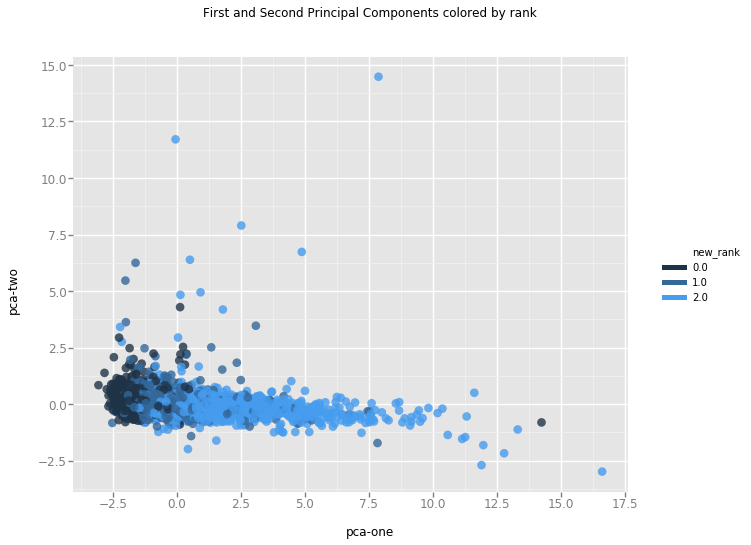

<ggplot: (284166513)>

In [6]:
from ggplot import *
from sklearn.decomposition import PCA

pca = PCA(2)
pca_result = pca.fit_transform(new_feat.values)

new_feat['pca-one'] = pca_result[:,0]
new_feat['pca-two'] = pca_result[:,1] 

chart = ggplot( new_feat.loc[:7000], aes(x='pca-one', y='pca-two', color ='new_rank') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by rank")
chart

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5738 samples in 0.006s...
[t-SNE] Computed neighbors for 5738 samples in 0.860s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5738
[t-SNE] Computed conditional probabilities for sample 2000 / 5738
[t-SNE] Computed conditional probabilities for sample 3000 / 5738
[t-SNE] Computed conditional probabilities for sample 4000 / 5738
[t-SNE] Computed conditional probabilities for sample 5000 / 5738
[t-SNE] Computed conditional probabilities for sample 5738 / 5738
[t-SNE] Mean sigma: 0.555157
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.231247
[t-SNE] Error after 300 iterations: 2.052384


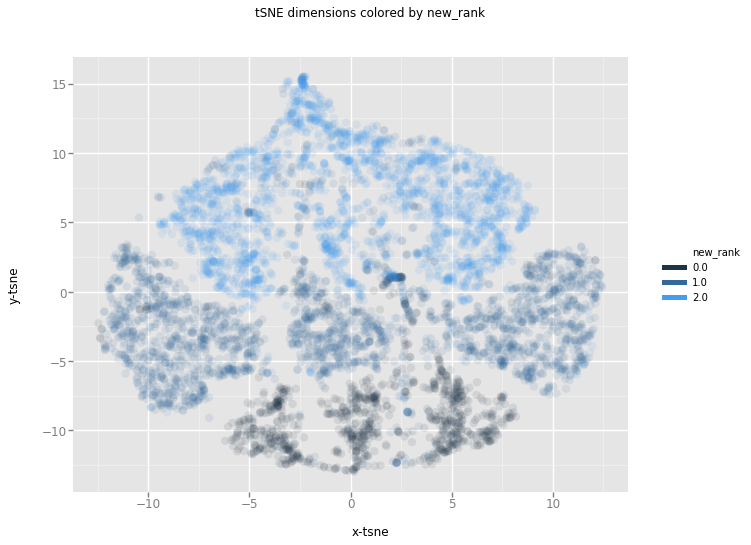

<ggplot: (-9223372036561951372)>

In [7]:
from sklearn.manifold import TSNE

n_sne = 7000

tsne = TSNE(verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(new_feat.loc[:n_sne].values)

df_tsne = df.loc[:n_sne].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='new_rank') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by new_rank")
chart

In [8]:
# df.to_csv('clean&normed_profiles_df.csv', index= False)